In [4]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [6]:
class LyftUdacity(Dataset):
    def __init__(self,img_dir,transform = None):
        
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask
    
data_dir = ['../input/lyft-udacity-challenge/data'+i+'/data'+i for i in ['A','B','C','D','E']]

In [8]:
def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

t1 = A.Compose([
    A.Resize(160,240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

train_batch,test_batch = get_images(data_dir,transform =t1,batch_size=8)

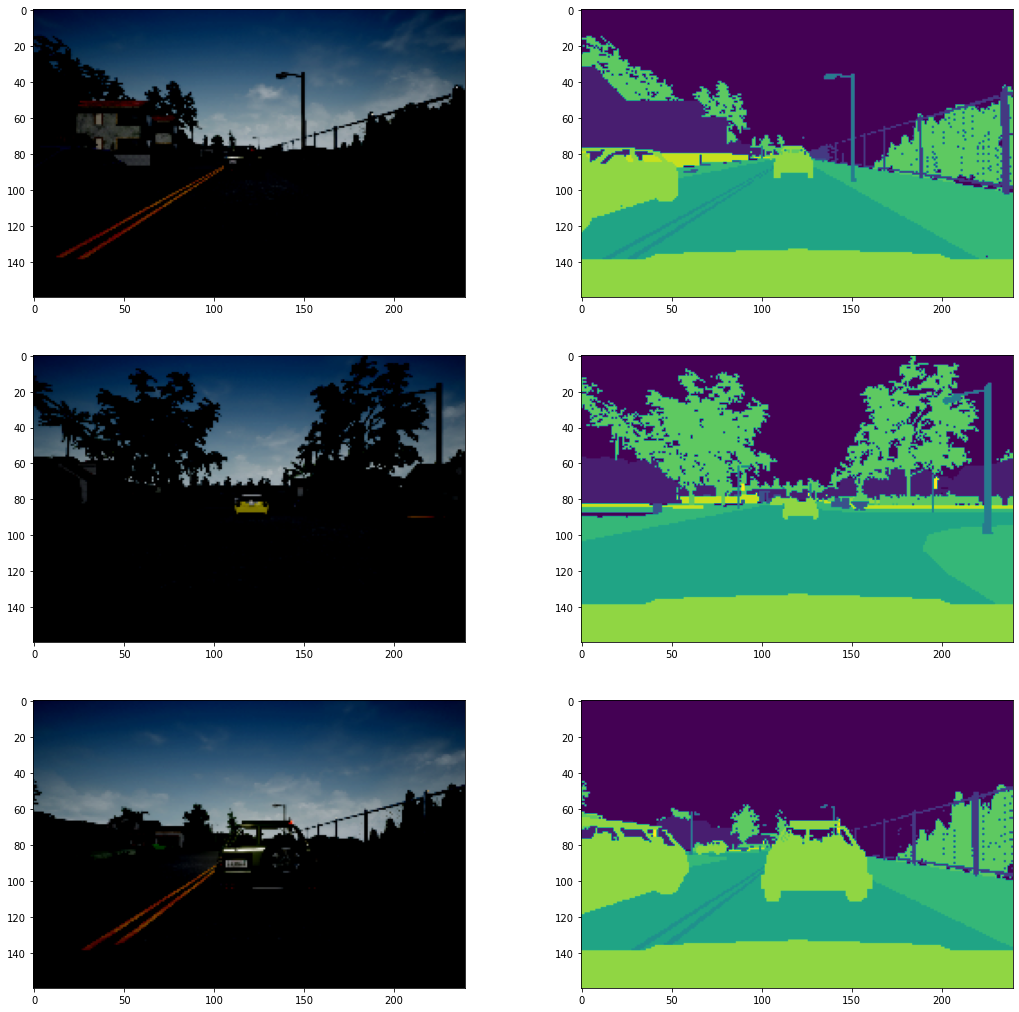

In [9]:
for img,mask in train_batch:
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [14]:
import torch.nn.functional as F

class SegNet(nn.Module):
    
    def __init__(self):
        super(SegNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool5 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool4 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv5_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_3 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_3 = nn.ConvTranspose2d(512, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_1 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.ConvTranspose2d(64, 23, kernel_size = 3, stride = 1, padding = 1)

        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)
    
    def forward(self, x):
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x, idxs1 = self.pool1(x)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
        
        size_4 = x.size()
        x = self.conv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs4 = self.pool4(x)
        
        size_5 = x.size()
        x = self.conv5_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs5 = self.pool5(x)

        
        x = self.unpool5(x, idxs5, output_size = size_5)
        x = self.deconv5_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        
        x = self.unpool4(x, idxs4, output_size = size_4)
        x = self.deconv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv4_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.deconv1_2(x)
        
        return x

In [15]:
from torchsummary import summary
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = SegNet().to(DEVICE)

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
         MaxPool2d-5  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
       BatchNorm2d-7        [-1, 128, 128, 128]             256
            Conv2d-8        [-1, 128, 128, 128]         147,584
       BatchNorm2d-9        [-1, 128, 128, 128]             256
        MaxPool2d-10  [[-1, 128, 64, 64], [-1, 128, 64, 64]]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]         590,080
      Batch

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [17]:
LEARNING_RATE = 1e-4
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [18]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

100%|██████████| 500/500 [03:03<00:00,  2.73it/s, loss=0.106] 


In [19]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [20]:
check_accuracy(train_batch, model)

Got 23946504/153600000 with acc 15.59
Dice score: 6.547511100769043


In [21]:
check_accuracy(test_batch, model)

Got 5951303/38400000 with acc 15.50
Dice score: 6.549428462982178


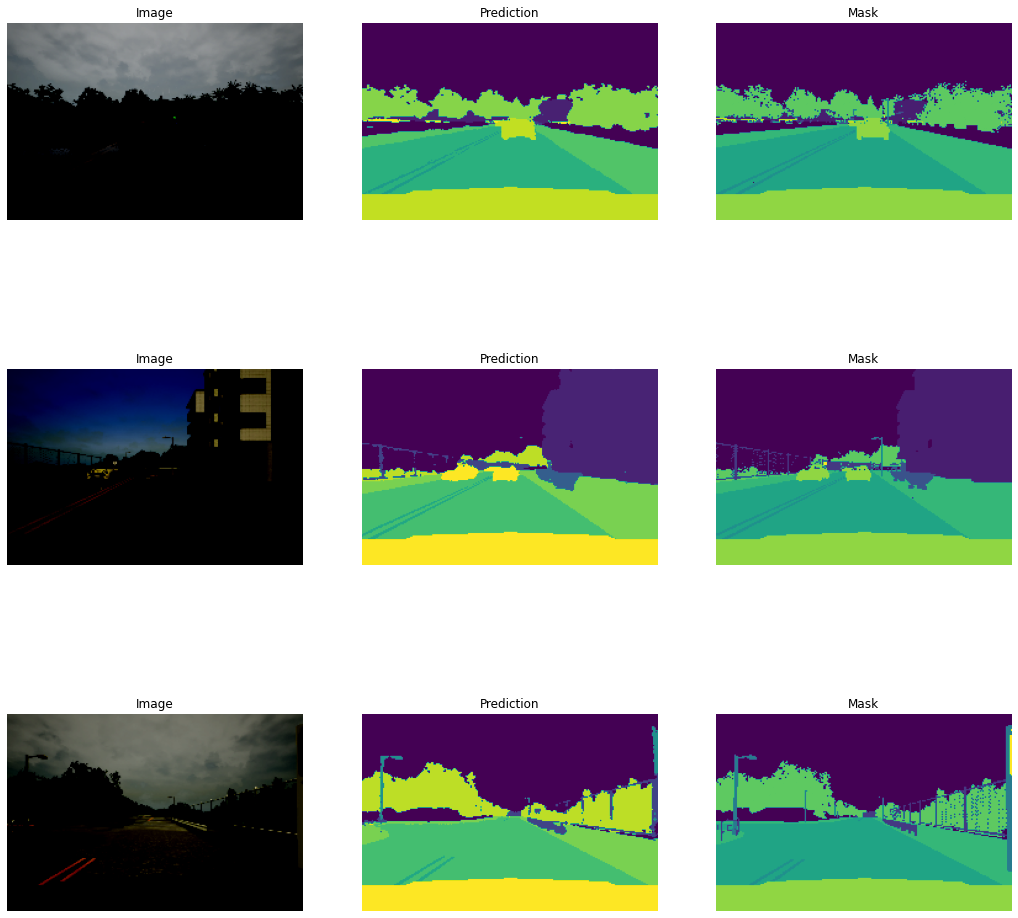

In [22]:
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [23]:
torch.save(model, 'model.pt')